In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

## Data loading and preprocessing

Importing the Flickr8k image dataset and its respective captions

In [3]:
token_path = "Flickr8k_text/Flickr8k.token.txt"
train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'Flickr8k_Dataset/Flicker8k_Dataset/'
glove_path = 'glove.6B'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


Image ids and their respective captions are stored in the above format. 
  
  
We now create a dictionary named 'descriptions' with the image id as key and the corresponding captions as values.

In [4]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

Text cleaning to get rid of punctuations and converting descriptions to lowercase

In [5]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

Visualizing a sample image

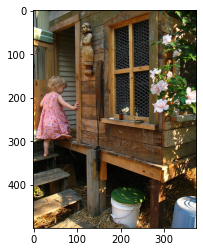

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [6]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

A vocabulary of all unique words present across the 8000 * 5 captions across the dataset is created.  
We see that there are 8828 unique words.

In [7]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


Saving image ids and their respective captions in the same format as Flickr8k.token.txt

In [8]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

Loading all training image ids from the Flickr_8k.trainImages.txt file:

In [9]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier = line.split('.')[0]
        dataset.append(identifier)

train = set(dataset)

We now save all the training and testing images in lists named as train_img and test_img respectively:

In [10]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

The descriptions corresponding to the training images are loaded into a dictionary and two tokens named as 'startseq' and 'endseq' are added to every caption

In [11]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

List consisting of all training captions:

In [12]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

To increase the robustness of our model, the vocabulary is reduced to include only those words which occur at least 10 times in the entire corpus.

In [13]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


Creating two dictionaries to map words to an index and vice versa

In [14]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

Finding maximum length of a caption

In [15]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


## Glove Embeddings

Word vectors are used to map words to a vector space where similar words are clustered together and words that differ are separated.  
Here, we are using Glove and not Word2Vec as Glove also incorporates global word co-occurence and not just the local context of words.  
  
For our model, we map the 38-word long caption to a 200-dimension vector using Glove.

In [16]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

We create a matrix of shape (1660 (total vocabulary size), 200)

In [17]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    print(word)
    print(embedding_vector)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

startseq
None
a
[ 2.4169e-01 -3.4534e-01 -2.2307e-01 -1.2907e+00  2.5285e-01 -5.5128e-01
 -8.0336e-02 -8.1767e-03  3.1136e-01 -4.5101e-01  2.4661e-01  3.6441e-01
  9.4336e-01 -3.5420e-02  7.8048e-01 -3.9765e-01  3.1125e-01 -1.7743e-01
 -4.1989e-01 -3.7815e-01  6.7230e-01  3.1716e+00  3.2496e-02 -3.1640e-02
  5.8068e-01 -4.4458e-01 -5.5612e-02  1.8052e-01  2.8572e-01  9.5870e-02
  2.1437e-01  4.9731e-02  1.8720e-01  1.1914e-01  2.7408e-02 -8.0608e-01
 -3.0835e-01 -8.9737e-01 -1.9772e-01  2.6741e-02 -3.8765e-01  1.1659e-01
 -2.0110e-01  2.0101e-01 -7.9133e-02 -5.0954e-02  6.0189e-03  3.3470e-01
 -2.1118e-01  7.4042e-02 -2.8141e-01 -5.9615e-02 -3.5296e-01  6.4748e-01
  5.3908e-02 -3.1376e-01 -3.6622e-01 -2.7755e-01  2.2676e-02  4.8811e-02
  1.4312e-01 -1.8580e-01 -5.6964e-01 -5.4119e-01  1.8616e-01  1.8854e-01
  2.7521e-01 -1.7835e-01 -3.7438e-01  1.2109e-01  1.8610e-03 -9.2127e-03
  1.0186e-01  9.8081e-02 -3.7245e-01  6.6415e-01  5.7366e-02 -4.3845e-01
 -4.0525e-01 -5.5959e-01 -1.1343e-0

  0.2635     0.2121   ]
toward
[-2.6055e-01  2.0839e-01 -6.0069e-02  2.5573e-01 -4.8095e-01 -2.7689e-01
  7.5894e-02 -2.1326e-01 -5.9039e-02  5.0802e-01 -5.7497e-02 -4.5010e-02
  4.3129e-03 -1.3556e-01  5.6377e-01  5.8902e-02 -1.9814e-02 -1.1413e-01
  6.6390e-01  3.5306e-01  5.3339e-01  2.4880e+00 -2.2684e-01  9.3584e-01
  6.5905e-01  8.1867e-01  2.2309e-01 -9.6366e-02 -4.3344e-01 -7.6412e-01
 -3.6846e-01 -2.0696e-01 -4.9601e-01  4.5423e-01 -7.8654e-01  4.2913e-01
 -1.0517e+00 -6.2530e-02 -5.0085e-01  1.0017e+00  1.2165e-01  4.0716e-01
  2.6019e-01  7.1678e-01  2.0572e-01 -1.4173e-01  5.6208e-02  6.5033e-01
  4.0527e-01  9.2080e-01 -3.1995e-01  4.3783e-01  1.3756e-01  3.2788e-01
  3.2559e-02  2.8004e-01 -3.9867e-02 -6.8664e-02  8.9565e-02  4.7007e-01
  1.8457e-01 -3.1966e-01 -2.1542e-01  2.7993e-01  9.0271e-01  4.8272e-01
  4.4375e-01  3.9934e-01 -1.3868e-01 -5.2214e-01 -1.4718e-01  4.8589e-01
 -2.9486e-01  4.9027e-02 -4.5643e-01  3.8329e-02 -7.1592e-02 -2.1284e-01
  1.0104e-01 -1.1489

 -0.67336    0.39687  ]
rope
[ 0.24684   -0.29027   -0.93053   -0.41238   -0.099909   0.10263
 -0.14236   -0.45041   -0.74297   -0.12904    0.012927  -0.24042
  0.46042   -0.29803    0.045864  -0.5037    -0.23562   -0.1307
  0.59332    0.15974    0.14557    0.55984    1.2141    -0.31872
  0.83758   -0.49621    0.38332    0.49659    0.0048764  0.25782
  0.77081    0.23601    1.0523    -0.13934    0.11853    0.1283
 -0.55085   -0.074909  -0.068674  -0.60126    0.21151    0.046556
 -0.45502   -0.57181    0.44983    0.26312    0.31659    0.39783
 -0.32462    0.36264    0.2799     0.50183   -0.0071482 -0.02708
  0.53439    0.14395   -0.5841    -0.29691    0.28484   -0.052597
 -0.48672    0.37494    0.031913   0.58327    0.18274    0.044087
 -0.097626  -0.26683   -0.23396   -0.42937    0.060398  -0.29829
 -0.15113   -0.15162   -1.0355    -0.40998    0.36551   -0.80299
  0.088932   0.46936    0.33353    0.077893  -0.13446   -0.73007
 -0.57503   -0.26941   -0.25809   -0.24422    0.53046   -1.2

 -0.42108    0.18817  ]
collar
[ 0.39292   -0.77003   -0.28123   -0.2714     0.58432    0.048752
 -0.27896    0.22366   -0.35167    0.20149    0.050255  -0.71637
 -0.32607   -0.37523    0.72391   -0.31818   -0.082371   0.17449
  0.41644    0.29359    0.57893    1.0071     0.024597  -0.19318
  0.054437  -0.11809    0.28624   -0.34523   -0.78243   -0.1565
 -0.19069   -0.43113    0.33466    0.79967    0.26011    0.15202
  1.0539    -0.36455    0.73981    1.0411     0.010122  -0.48585
  0.36029   -0.027395  -0.10461   -0.20758    0.74338   -0.094338
  0.63589   -0.16169    0.26257    0.31009    0.19117    0.69006
  0.045719  -0.044386  -0.18523   -0.25837    0.28261    0.041561
  0.044733  -0.19918   -0.69456   -0.1456    -0.72617    0.46824
 -0.53558   -0.43951    0.25963   -0.11916   -0.17217    0.098337
 -0.098674  -0.34762   -0.56409   -0.30485    0.12174    0.052841
  0.43611    0.42542    0.29408   -0.25647    0.37801    0.0063812
 -0.053094   0.5834    -0.25114    0.57079    1.3318 

 -0.161     -0.16884  ]
stroller
[ 0.34316   -0.40602   -0.26024    0.62703   -0.16989   -0.67861
  0.24597   -0.084925  -0.33465   -0.25281   -0.10892   -0.085349
  1.0024     0.41911   -0.51624   -0.2149    -0.3942    -0.72826
  0.39961    0.15141    0.44297   -0.24664    0.191      0.17143
  0.44857   -0.4765     0.15889   -0.47068   -0.10578   -0.65086
 -0.8235     0.17154   -0.26811   -0.40542   -0.072847   0.57536
  0.64419   -0.27192   -0.25658   -0.089525   0.46096   -0.18983
 -0.60861    0.030381   0.72579    0.18439   -0.01025   -0.39657
 -0.61365    0.50736    0.79084    0.1545     0.72295   -0.48963
 -0.24594    0.59697    0.28009   -0.97323    0.3195     0.38067
  0.3607     0.13225   -0.077285   0.076021   0.061869  -0.18303
 -0.24354    0.052818  -0.27654   -0.16826   -0.11232   -0.31889
  0.027735  -0.041797  -0.6192    -0.33824   -0.47204    0.11827
  0.59452    0.45629    0.16135    0.11503   -0.18671   -0.78715
  0.58525   -0.18677    0.52856   -0.48723   -0.061096  

  0.087218  -0.23538  ]
backpack
[ 0.38427   -0.28207   -0.1511    -0.81683    0.33275   -0.56554
 -0.012716  -0.017033  -0.19353   -0.29424   -0.49299    0.17566
  0.89143    0.37282   -0.38566   -0.23604   -0.36266   -0.17557
 -0.063029  -0.39201    0.50003    0.47395    0.0033017 -0.44123
 -0.42798   -0.82303   -0.62411   -0.16709   -0.71356   -0.39557
 -0.29006    0.23822    0.18773   -0.32792    0.11056    0.76731
  0.26919    0.36825    0.25555    0.28334    0.33088   -0.10398
 -0.24252    0.34791    0.34509    0.022249   0.47666   -0.36737
 -0.025928   0.53133    0.73236   -0.53655   -0.12243    0.13193
 -0.11628    0.91172   -0.39949   -0.3511    -0.10513    0.39774
  0.4588    -0.5483    -0.56503   -0.11195   -0.76407   -0.077674
 -0.070121  -0.74601   -0.74206   -0.93352    0.0045588  0.10522
 -0.30686   -0.099188  -0.48674   -0.67388   -0.26013   -0.13333
  0.80007   -0.039482  -0.15914    0.61203    0.016655  -0.049862
 -0.020996  -0.10036   -0.15731    0.062773  -0.14829  

 -6.8084e-01  3.5917e-01]
leans
[ 0.10661   -0.064624   0.36562    0.79716    0.18152   -0.10805
  0.73047    0.29689    0.28736   -0.48492    0.49628    0.026161
  0.7211    -0.37071    0.026555   0.39183   -0.24962   -0.29955
 -0.015659   0.28083    0.59673    0.20857   -0.51958   -0.036426
  0.2126     0.22768    0.20661    0.28311   -0.55097   -0.78543
 -0.41003   -0.39052   -0.16308    0.36172   -0.36266    0.40737
 -0.18153    0.032017  -0.52092    0.21546   -0.0083123  0.55491
 -0.16762    0.081034   0.32      -0.35007    0.40845    0.15729
  0.31952    0.61152    0.01088    0.46075    0.46221   -0.043155
 -0.16896    0.15552    0.015734  -0.26263    0.10761    0.66785
 -0.19022   -0.65316   -0.094579  -0.11433    0.10476    0.42597
  0.16802   -0.19752   -0.20294   -0.42269   -0.33849    0.52227
 -0.52856    0.14329   -0.45836   -0.54258   -0.33068   -0.42529
 -0.098307   0.31628    0.21399   -0.37883    0.54226   -0.77963
  0.43497   -0.083458  -0.33228   -0.23942    0.070987 

 -0.53533   -0.0091845]
mountains
[ 1.4611e-01 -6.3516e-01  2.2973e-01  1.0174e-01  3.0907e-01 -3.1705e-01
 -1.5126e-01 -4.5699e-01 -3.5631e-01 -6.8330e-01 -2.1488e-01 -2.3963e-01
  5.0517e-01  1.4587e-01  6.3089e-01  5.4905e-01 -2.2333e-01  3.5766e-01
 -1.4866e-02 -3.7068e-02  5.2819e-01  1.3937e+00  2.2956e-01  2.0868e-01
  8.4950e-01 -1.5853e-01 -1.5034e-01  2.2260e-01 -3.8692e-01  3.5660e-01
 -5.2428e-01 -1.1276e-01 -1.2501e-01  5.5864e-01  2.4900e-01 -5.4448e-01
 -1.3802e+00  1.7632e-01  8.1773e-01 -1.7881e-01 -1.0366e-01  1.4297e-02
 -3.8923e-01 -3.8003e-01 -6.3238e-02 -1.5172e-01 -1.9797e-01 -2.1667e-01
  2.6272e-01 -7.9778e-02 -3.7376e-02  1.3595e-01  1.8419e-01 -1.3984e-01
  4.5965e-01  1.2482e+00 -5.6200e-01 -3.4702e-01  1.5629e-01  6.0310e-02
 -4.1498e-01  1.3777e-01  4.5497e-01  2.2479e-01 -4.1175e-01  7.7055e-02
  1.7342e-01 -1.6623e-01 -1.6595e-03 -1.7374e+00 -3.9821e-01 -6.1204e-01
 -6.6419e-02  5.6937e-01  8.2423e-01  4.2336e-01 -3.7835e-01 -4.8605e-01
 -5.9458e-01 -6.6

 -2.3647e-01  2.2993e-01]
faces
[ 9.5530e-02 -1.6737e-01 -6.3063e-01 -1.8390e-01  1.9846e-01  9.0512e-01
  3.6681e-01 -3.1334e-02  1.7805e-01 -4.5254e-02 -2.5620e-02  1.2689e-01
 -3.5962e-01  1.2995e-01  9.8745e-01 -2.6641e-01  2.6322e-01  8.3971e-02
  8.5175e-02 -3.1228e-01  7.7160e-01  2.4343e+00 -2.1643e-01 -1.8609e-01
  2.5810e-01 -2.7778e-01 -3.2536e-02 -2.7793e-01  1.0404e-01 -4.9402e-02
 -4.8955e-01 -8.8287e-01  7.2870e-02  5.6177e-01 -3.4181e-01 -6.9271e-02
 -3.7992e-01 -2.8729e-01  9.7589e-02  4.9160e-01 -5.9715e-01 -2.7228e-01
 -4.0499e-01  8.6421e-01  3.3087e-01 -3.7439e-01 -2.0314e-03  1.1462e-01
 -2.5488e-01  1.7175e-01  4.1131e-01 -1.1884e-01 -2.0353e-01 -4.9613e-04
  1.0428e+00  4.8527e-02 -6.3262e-01 -3.2337e-01  3.3559e-01  6.0353e-01
 -1.1748e-01  6.0760e-01  3.8238e-01 -2.3941e-02  8.6139e-01 -2.9771e-01
  1.7382e-01 -1.6808e-01 -3.3534e-01  9.4301e-02  3.3186e-01  1.0414e-01
 -1.1545e-01  1.0959e-01  1.9641e-01  2.0789e-01 -8.7422e-01  2.7541e-02
 -1.2295e-01 -3.530

 -0.65019    0.14263  ]
resting
[-0.39501    0.21212    0.35431   -0.0083693 -0.3228    -0.28492
  0.46537   -0.39429    0.16258   -0.20909   -0.043455  -0.38947
  0.38554    0.73135    0.33364    0.14333    0.19397    0.44375
  0.02265   -0.21508   -0.082612   1.097      0.79998   -0.15861
  0.18586   -0.2942     0.35754    0.39051   -0.72594    0.31526
  0.51805   -0.52641   -0.094905   0.52679    0.18509    0.14881
 -0.13917   -0.059976  -0.26626    0.33203   -0.0093135  0.1914
  0.26118    0.31214    0.048834   0.59556    0.061684  -0.24772
 -0.13485    0.51694   -0.30935    0.10233   -0.26757    0.42588
  0.13475   -0.06467    0.56724   -0.62143   -0.22414    0.17258
 -0.25441   -0.16898   -0.34982   -0.45423   -0.56242    0.067639
  0.037541  -0.0048059 -0.065024  -0.050874   0.060814  -0.57948
 -0.11242    0.52618   -0.080694  -0.63485   -0.27998   -0.93571
 -0.28579    0.21303   -0.32427   -0.041551   0.21267   -0.50101
  0.81171    0.63516    0.73325   -0.4311    -0.17213   -0

  0.16251    0.24632  ]
watch
[ 8.6892e-01  2.3822e-01 -6.1385e-01 -5.7118e-01 -4.7405e-01 -3.7876e-03
 -3.6406e-01  2.7454e-01  9.1425e-02  1.9755e-01  9.8624e-02  2.3183e-01
  3.5018e-01 -3.0006e-01 -2.9300e-02 -1.9190e-01 -2.2812e-01  6.2873e-01
 -2.7343e-01  2.0234e-01  7.1970e-02  1.6687e+00 -2.9206e-02 -3.9194e-01
 -1.2168e-01 -3.6784e-01  1.5848e-01  3.0106e-01 -2.9061e-01 -2.7422e-01
  1.0633e-01  1.9232e-01  1.6958e-01  3.9497e-02 -1.8672e-01 -1.0647e-01
 -2.4056e-01 -9.1826e-02  4.3249e-01 -6.5210e-02  1.8072e-01  3.2750e-01
  6.3738e-01  6.5817e-01 -2.5951e-01  6.7182e-01  9.6189e-01 -6.0682e-01
  7.4749e-02  7.5849e-02  2.3927e-01  9.8000e-02 -3.2888e-01 -5.4973e-01
 -2.4730e-01  1.2131e-01  2.4332e-01 -4.9811e-01 -5.1394e-02  1.8629e-01
  1.0579e-01 -1.4824e-02  1.9960e-01  9.4391e-02 -1.6904e-01  5.2249e-02
  4.4394e-02 -3.5623e-02  2.4420e-01 -2.1979e-01  5.6313e-01 -1.1375e-02
  2.1303e-01  3.0767e-01  1.9310e-01 -8.3384e-02 -1.8527e-01 -2.2471e-01
 -2.5876e-01  3.3150e

 -5.7858e-01  8.9480e-01]
party
[-6.5865e-01  5.3423e-01  4.3777e-02  6.7393e-01  1.6602e-01 -4.1741e-01
  3.9818e-01  5.3211e-01 -3.3676e-01  7.9238e-01 -3.1563e-01  4.4786e-01
  2.5974e-01 -5.9847e-01  2.0954e-01  4.5330e-01  5.9771e-01  4.0166e-01
 -3.2031e-01 -2.5832e-01  7.7701e-01  2.9981e+00 -3.5204e-01  6.2900e-01
  2.8480e-01 -2.4623e-02  3.4439e-01 -1.4069e-01 -6.8782e-01  6.2096e-01
 -5.1506e-01 -7.2010e-01  3.0794e-01 -3.7843e-01 -4.9103e-01  1.0848e+00
  4.4457e-01 -4.6116e-02  1.4095e-01  1.3767e-01  2.5804e-02  2.0366e-01
 -2.8700e-02 -1.3788e-01  2.2944e-02 -3.2601e-01  1.3869e-01  9.5038e-01
  1.4023e-01  1.3031e-01 -6.2936e-01 -8.1791e-01  4.2066e-01  1.8227e-01
 -3.8384e-01  1.9960e-01  8.0223e-01 -7.3926e-01  3.0488e-01  6.8268e-01
 -2.0069e-02 -1.4479e-01 -1.6923e-01  1.7878e-01  6.7149e-01 -1.8140e-01
 -1.0353e+00  9.8209e-01  3.5636e-03  2.8201e-02  1.4808e-01 -5.8151e-01
  3.3226e-01  2.2428e-01  2.0088e-01  3.8332e-01 -5.3412e-01 -7.2728e-02
  1.5515e-01 -3.318

 -0.78733    0.72769  ]
stop
[ 1.6610e-01  5.5681e-01 -4.5479e-01 -2.3009e-01 -5.1592e-01  7.0951e-01
 -5.9760e-01 -1.1523e-01 -2.4319e-01  8.3325e-01 -1.1029e-01  4.6626e-01
  1.9111e-01  5.7111e-01 -4.2998e-02 -3.2583e-01 -1.1690e-01  9.7762e-02
  2.2659e-01  7.3881e-02  1.6442e-01  2.6563e+00  1.7613e-01  2.0187e-01
 -6.6088e-02  8.5251e-02  7.3893e-02  4.0632e-01 -1.0308e-01 -2.7238e-01
 -1.0660e-01 -3.3676e-01  8.4694e-02 -4.1425e-02 -1.0501e-01 -6.5415e-01
 -9.0227e-01  1.8868e-01  5.4282e-02  1.0166e-01  6.1736e-01  5.1602e-02
  2.2477e-01  7.1686e-01  2.3488e-01  3.2965e-01 -1.8713e-01 -1.3571e-01
  4.9770e-02  3.2367e-01  5.1758e-01  2.7173e-01  2.7829e-01 -3.1017e-02
  3.4043e-01  2.8687e-03 -4.5762e-01 -4.3516e-01  2.0769e-01  2.3585e-01
  4.8045e-02 -4.9824e-01 -8.1457e-03 -5.9937e-02 -2.0918e-02  1.4158e-01
  3.5852e-02  2.0157e-01  2.0233e-01  1.3891e-01  1.1140e-01  2.3276e-01
  2.9076e-01 -4.8627e-02 -6.7431e-01  5.9065e-01  4.1473e-02  2.2858e-01
 -1.2273e-01 -3.5965e-

 -3.9924e-03  3.3775e-01]
neon
[ 0.11806   -0.14479   -0.66442    0.11658    0.24844    0.52069
  0.24179    0.78115    0.13263   -0.35374    0.56411    0.33072
  0.40022   -0.20984    0.46677   -0.26459    0.29466    0.79225
  0.8845    -0.20687    0.51935    0.33563    0.22415   -0.5924
  1.0816    -0.25593   -0.37013    0.077756  -0.7265     0.79545
 -0.65194   -0.092107  -0.11967    0.27747    0.20259   -0.65075
  0.45631   -0.028691   0.89503    0.5767    -0.12753    0.31409
  0.10491    0.71824    0.48781    0.23764    0.3686    -0.22126
 -0.73171    0.7838     0.17387    0.017401   0.52686   -0.033705
  0.10547    0.24796   -0.60229   -0.0031518 -0.40252   -0.30659
 -0.30594   -0.42426    0.11491   -0.15376   -0.55709   -0.27894
 -0.87795   -0.73005    0.58978    0.20187    0.048342   0.27324
 -0.77603   -0.41479    0.14423   -0.23521    0.44499    0.48091
  0.14176   -0.33669   -0.17119   -0.6643    -0.034523  -0.67662
 -0.16065   -0.34526    0.77633    0.18234    0.41483   -0.

 -0.72372    0.084745 ]
benches
[ 6.8571e-01 -3.6773e-01 -2.2700e-01  6.3380e-01 -6.9414e-04  2.3149e-01
  4.4363e-02  2.0039e-01 -7.6288e-01 -1.9288e-02  4.5144e-01 -3.5389e-01
  4.9513e-01 -9.1585e-02 -7.7597e-02  2.9512e-01  2.1438e-01 -3.3618e-01
  1.0415e+00  4.8937e-01  6.0709e-02  9.4276e-01  1.3733e-01 -3.8172e-01
  3.3536e-01 -3.1784e-01  1.6321e-02 -6.4159e-01 -2.8162e-01 -9.0512e-01
  4.3878e-02 -4.6716e-01 -4.3369e-02  5.0145e-01 -6.2017e-01  8.8363e-02
  3.7871e-01 -2.4491e-01  1.0789e+00 -1.9254e-02  7.8737e-01  6.1670e-01
  3.5789e-01 -8.9600e-02  6.1636e-01  3.8754e-01  5.5995e-01 -2.3065e-03
 -3.8971e-01  7.3463e-01 -9.7031e-01  3.2290e-01  1.6494e-01  4.8351e-01
  1.8322e-01  7.7684e-01  7.5779e-01 -3.8789e-01  1.7334e-01  4.9016e-01
 -2.0547e-02  2.9169e-02 -9.0865e-02 -3.2716e-01 -2.7497e-02  4.3251e-01
 -8.3870e-01 -4.5858e-01 -3.7462e-02 -2.1293e-01 -3.0598e-01 -5.9901e-01
  5.1067e-01  3.6712e-01  2.0115e-01 -5.7444e-02 -2.0480e-01 -1.8155e-01
 -2.0063e-01 -1.880

 -9.7244e-02 -1.1551e-01]
lots
[ 0.54965   -0.14147    0.19619    0.039725  -0.17219   -0.027286
 -0.83567    0.095255  -0.44423    0.61321    0.0080477  0.075479
  0.24511    0.010353  -0.2672     0.30444   -0.50989    0.25412
  0.5745     0.17338   -0.086945   1.6161     0.13559   -0.062704
 -0.27854   -0.6046    -0.4785     0.11191   -0.18677   -0.51201
 -0.37889   -0.27081   -0.23674    0.2837     0.13173   -0.082253
  0.11648    0.21429    0.50619    0.30508    0.59537    0.42713
 -0.17337   -0.11759    0.10207    0.069847   1.0962    -0.36904
 -0.37821    0.4752    -0.14288   -0.32399    0.14997    0.70069
  0.38545   -0.051942  -0.10582   -0.023666   0.01116   -0.17636
 -0.31729    0.33716   -0.39281   -0.10142   -0.19182   -0.14462
 -0.41394    0.33061    0.48835   -0.3905     0.24277   -0.74348
 -0.3914    -0.45311    0.66305    0.26784   -0.33826   -0.083857
 -0.36217    0.07438   -0.53035    0.17083   -0.5553     0.10834
  0.29869   -0.27114    0.11962   -0.43115    0.60299 

 -0.23438    0.50509  ]
dirty
[-7.2116e-03 -6.6455e-01 -3.2642e-01 -1.6324e-01 -2.2552e-01  8.6658e-01
 -3.5640e-01  2.5506e-01 -4.4618e-01 -1.0149e-01 -4.6342e-01 -9.1564e-02
 -6.4369e-01  1.7066e-01 -1.1394e-01 -2.5084e-03 -2.7971e-01  6.2172e-01
 -3.3126e-01  1.1405e-01  3.4164e-01  1.3886e+00  2.1445e-02  5.0281e-01
  7.1291e-01 -1.5629e+00 -2.6420e-02 -2.9745e-01 -1.7250e-01 -3.1748e-02
 -3.8230e-01 -5.3247e-01  1.6484e-01  3.3333e-01 -2.7484e-01  1.0076e-01
  1.2662e-01 -4.0351e-01  6.1103e-01 -1.2494e-02  9.9187e-02  1.9675e-01
 -3.7571e-01 -2.0029e-01  4.8959e-01 -1.4332e-01  7.1304e-01 -3.8693e-01
  8.4225e-01  7.2468e-01 -7.0754e-03 -1.0361e-01  3.0336e-01  3.1026e-02
  2.0403e-01 -3.0505e-01 -4.4913e-01  1.3793e-01 -2.0712e-02 -3.6797e-01
 -3.3221e-02 -4.5573e-01  1.2357e-01  2.7761e-01 -2.6091e-01  5.9924e-02
  2.3386e-01 -5.0936e-02  7.3520e-02  4.3994e-03  1.9236e-01 -6.7519e-01
  7.5942e-02  2.3520e-01 -5.9248e-04 -2.4217e-01 -2.4064e-01  1.7697e-01
  2.7989e-01 -3.5690e

 -0.90532    0.060089 ]
skimpy
[ 1.0576e+00 -7.1122e-01 -5.7807e-01  2.2151e-01  2.8252e-01  5.9281e-02
  4.9204e-01  3.2850e-01 -1.4568e-02 -2.9806e-01 -5.7631e-02  7.1852e-01
  4.5374e-01 -7.0556e-01 -3.5160e-01 -1.6422e-01 -5.6056e-01  2.9992e-01
 -6.1314e-01  1.7875e-01 -1.1059e-01 -2.6730e-01  2.3620e-01 -1.4537e-01
  1.9051e-01  4.0508e-01 -2.2888e-01 -4.5902e-02 -3.9000e-01  3.4438e-01
 -6.4796e-01 -2.7342e-02  1.1447e-01  7.7893e-01 -3.9270e-01  8.8871e-01
  2.1260e-01 -4.7259e-01  1.0935e-01 -1.3377e-01  2.9510e-01 -4.4091e-01
 -6.5883e-02 -1.3385e-01  1.2391e-01  1.6925e-02 -2.3357e-01 -3.4441e-01
 -5.4155e-01 -1.3095e-01  1.8921e-01 -5.8163e-01  3.2825e-01  3.7992e-01
 -5.3487e-01  1.4052e-01 -5.1178e-01 -1.9761e-01 -1.4614e-01 -5.7275e-01
 -1.0396e-01 -2.4174e-01 -2.9457e-01  5.4646e-01 -1.9761e-01  3.9279e-01
  2.1234e-01 -5.7488e-02  2.7709e-01 -4.3555e-01  5.6674e-01 -4.8117e-01
 -4.7210e-01 -6.9679e-02  1.3435e-01  4.1950e-01 -6.8145e-01 -1.0610e+00
  3.0135e-01 -2.3577

  0.28842    0.33208  ]
throw
[ 7.3191e-01 -8.5238e-02 -1.0707e+00  8.7584e-02 -6.8275e-01  2.6631e-01
 -5.7185e-01 -4.5618e-01  1.8897e-01  3.6054e-01 -4.3539e-01 -1.4745e-01
  3.8949e-01  1.3598e-01 -5.5406e-02 -1.3670e-01 -6.3719e-01 -3.0510e-01
 -3.6279e-02 -4.6570e-01  5.7129e-01  1.9411e+00  6.1475e-04  2.6434e-01
  1.2993e-01 -2.4922e-01 -1.6462e-01  6.1110e-02 -6.5123e-01 -9.6008e-01
  1.0448e-01 -4.6250e-01  1.2027e-01 -3.2294e-01 -3.2660e-01  2.4821e-01
 -7.6140e-02 -7.6710e-01 -4.1630e-01 -1.6805e-01  3.8135e-01 -2.6579e-01
  3.4615e-01  2.6063e-02  3.1294e-03  2.5800e-01  3.9075e-02  9.3867e-02
  7.7802e-02  7.8924e-01  3.3912e-01 -1.6538e-01 -2.7826e-01  1.1633e-01
  3.1319e-01  2.0288e-01  8.5424e-02 -6.7973e-02  2.5052e-01  3.4668e-01
 -2.0780e-01  4.5732e-01 -1.9506e-02  1.6345e-02  9.5704e-01  3.4856e-01
 -1.8164e-01 -8.6314e-02  1.5989e-01 -4.4784e-02  4.5458e-01  7.4752e-02
  7.3892e-03 -5.2194e-01 -1.9162e-01 -2.0379e-01 -2.5625e-01 -7.7635e-02
 -1.3947e-01  5.6303e

  3.6483e-01  1.2194e-01]
curb
[ 0.16976    0.16667   -0.40638   -0.29558    0.14262    0.6693
 -0.39393   -0.24176   -0.51077    0.29296   -0.03167    0.31053
  0.14762   -0.16941   -0.35813    0.15495   -0.2515    -0.042912
  0.31636   -0.0044487 -0.087328   1.6633    -0.5521     0.75944
 -0.53087    0.15296    0.56056    0.50789   -0.3378     0.020206
 -0.53831   -0.4485     0.42651    0.34437    0.19051   -0.10848
 -0.25725    0.45783    0.4085     0.27526    1.8103    -0.46165
  0.1867     0.89088    0.52142   -0.19525   -0.025702  -0.20688
  0.34985    0.28073    1.0389     0.15171    0.29056   -0.19281
 -0.43344   -0.56532   -0.139      0.48139   -0.1208     0.56164
 -0.315     -0.102     -0.27506    0.28848   -0.064528   0.044858
  0.072633   0.24427   -0.38181   -0.44539    0.050708   0.58274
 -0.24136    0.28454   -0.38969    0.60414    0.60364   -0.20759
  0.2554     0.36813   -0.20487    0.035164  -0.53679   -0.16235
  0.32243    0.044512   0.73431    0.05265    0.61727   -

  1.6672e-01  1.2105e-01]
raising
[-3.0956e-02  1.4134e-01 -2.1010e-01 -9.2588e-02 -1.2910e-02 -1.6737e-01
 -2.1458e-02 -3.5404e-01 -2.3130e-01  9.3005e-01 -4.6152e-01  3.6008e-01
  5.1531e-02 -3.0692e-01  6.0256e-01  4.1234e-01 -2.6285e-01  1.7735e-01
  4.1497e-02 -1.3805e-01  3.1452e-02  2.2291e+00  1.3246e-02  2.7888e-01
 -3.2959e-02  1.2942e-01 -6.2504e-03  2.4600e-01 -6.4203e-01  2.0819e-01
 -2.2013e-01 -3.2624e-01  2.1477e-01  2.8307e-01 -2.6584e-01 -1.6768e-01
 -6.0731e-01  1.0076e-01 -1.2475e-01  2.4310e-01  8.6715e-01 -1.9001e-01
 -4.2062e-01  2.4603e-01  3.0537e-01 -1.4399e-01  5.2762e-01  7.6309e-02
 -1.8311e-01  2.0405e-01  1.4216e-01  3.0156e-02  3.7010e-01 -2.4086e-01
  1.8619e-02 -3.1149e-01  2.6169e-01  1.2161e-01 -6.2240e-01 -7.2507e-02
 -6.2044e-02  4.5211e-01 -5.6131e-01  8.2724e-02 -1.4068e-01 -2.4773e-01
  1.9997e-01  5.3397e-01 -2.7855e-01 -1.0441e-02  1.7531e-01  4.8115e-02
 -5.8036e-01  9.1372e-02 -2.3127e-01  7.6436e-01 -1.5904e-01 -1.5183e-01
  5.2479e-01  1.8

gather
[ 0.81222    0.15952    0.06727   -0.013385  -0.028437  -0.24705
 -0.14935    0.26669    0.031537   0.75438   -0.43607   -0.03478
  0.023708  -0.27743   -0.14921   -0.35174    0.040926   0.18885
 -0.65617    0.38422   -0.27104    1.5861    -0.31716    0.69591
  0.017838  -0.22951   -0.16939    0.18106    0.24353    0.45911
 -0.017098  -0.50685   -0.17385   -0.26396   -0.076792  -0.45606
 -0.12811    0.29331    0.44907    0.19436    0.87147    0.53721
  0.5486     0.37024   -0.29223    0.67575    0.35707   -0.33719
  0.37254    0.1823    -0.059586   0.035195  -0.40008    0.4849
  0.26718   -0.042993   0.56879   -0.069846   0.47156    0.061936
 -0.22532    0.71339    0.60171   -0.40829   -0.19076    0.078801
  0.15682    0.59084   -0.49051   -0.28305   -0.0051449  0.19278
  0.41705    0.14112    0.52959    0.077369   0.025532   0.13818
 -0.14083    0.21027   -0.091078   0.74911   -0.20073   -0.092573
 -0.34936    0.65592   -0.23043   -0.2609     0.78216   -0.68195
  0.048364   0.0

  1.5674e-02  3.6891e-01]
flags
[-1.2747e-01  2.9617e-01  1.4875e-01 -4.7688e-02  1.5918e-01  3.7331e-01
  2.3611e-01  6.4508e-01  1.1920e-01  7.1049e-01 -6.9545e-02  2.7080e-01
  2.0320e-02 -1.9386e-01  1.0482e+00 -7.1606e-01  1.2750e-01  7.4100e-01
  2.9263e-01 -6.9115e-01  4.1800e-01  1.0732e+00  1.1461e+00  1.5505e-01
  4.5577e-01 -2.0902e-01 -5.8955e-01 -7.1838e-01 -1.1203e+00 -4.3459e-01
  5.2295e-01 -7.8960e-01 -1.1401e-01 -2.8821e-02 -8.7067e-01  4.9651e-02
 -4.4552e-01  5.3088e-01  2.8026e-01 -4.1104e-02  2.0495e-01  8.2306e-01
  1.4311e-01 -5.2332e-01  5.1286e-01  4.3759e-02  1.2166e+00 -3.9726e-01
 -5.4266e-01  4.5098e-03  1.6349e-01 -5.0231e-01  1.2240e-01 -5.9580e-01
 -5.5170e-01  1.9867e-01 -7.3444e-01 -1.1791e-01  1.6289e-01 -4.6003e-01
 -2.8534e-01  1.8294e-01  4.8609e-01  6.0895e-01  3.4826e-01  1.1773e-01
 -3.2463e-01 -7.6877e-02  3.4327e-01 -2.4254e-01 -8.5736e-01 -5.4955e-03
  4.0685e-01 -3.2138e-01 -4.2043e-01  3.2917e-01  2.5101e-01 -9.5979e-02
  5.9796e-01  1.191

 -5.7396e-01  6.1482e-01]
itself
[-1.1828e-03  3.0767e-01  1.1454e-01  4.2060e-01  7.6239e-02 -4.6608e-01
 -1.5404e-01 -3.9606e-03  2.8804e-01  9.2281e-03 -8.4334e-02  1.8772e-01
 -4.0698e-01  9.7776e-02  1.8469e-01  1.7527e-02  8.9238e-02  3.6777e-01
 -1.6977e-01 -6.5592e-01  3.0961e-01  2.6991e+00 -3.9302e-01 -1.6152e-01
  3.8101e-01 -4.1015e-01  3.2291e-01  2.0572e-01 -3.0149e-01 -3.0284e-01
 -2.5462e-02 -5.0151e-01 -4.5415e-02 -1.3786e-01 -4.2496e-01 -1.9652e-01
 -1.4863e+00 -2.3348e-01  1.8416e-01 -3.0961e-01 -4.2038e-01  3.7079e-02
  3.1278e-01  5.1077e-01  1.6067e-01 -2.2026e-02  4.0774e-01  1.6451e-01
  6.9098e-03  2.7596e-01 -9.7136e-02 -1.7693e-01  2.0115e-01 -1.7965e-01
  2.4513e-01  3.8856e-01 -2.9569e-01 -4.4591e-01 -3.9098e-01  3.3732e-01
 -5.3369e-01 -1.3836e-01  1.3649e-01 -3.3592e-01  1.7003e-01  9.4295e-04
 -2.8407e-01  8.1175e-02 -4.0881e-01 -1.5368e-01  3.2445e-01  3.6314e-01
 -1.2048e-01  1.6517e-01 -5.6916e-01  4.5304e-01  3.1339e-01 -2.4490e-01
 -3.9864e-01 -1.20

 -0.6009     0.5053   ]
talk
[-3.1544e-02  4.9300e-01  2.4632e-01 -3.1777e-02 -4.3016e-01  4.0480e-01
 -7.7801e-01  2.1853e-01  2.0260e-01  7.2342e-01 -1.0626e-01  3.7464e-01
  1.9789e-01 -1.6937e-01 -2.0879e-01  4.1171e-02 -5.4858e-01  5.6580e-01
  3.2239e-01  6.7327e-01  5.1787e-01  2.0855e+00 -3.0021e-01  1.6769e-01
 -1.7010e-01 -8.3371e-03 -8.9091e-02  4.0903e-01 -1.9189e-01 -2.4985e-01
 -4.1168e-01 -5.1319e-02  1.0862e-01  2.2639e-01 -1.5524e-01 -6.8605e-01
 -4.1820e-01 -2.4775e-01  4.7809e-01  3.9015e-01  1.2137e-01  1.1231e-01
 -1.9576e-01  1.3841e-01 -1.2063e-01  3.0194e-01  7.1905e-01 -3.6541e-01
  2.1860e-01  2.8439e-01  3.5110e-01  4.1643e-01  2.0300e-01  7.5664e-01
  2.3972e-01  3.5132e-02  2.9739e-01 -1.4292e-01 -3.5330e-01  3.0618e-01
  3.5124e-01 -5.5892e-02  3.0276e-03  1.4785e-01 -1.8832e-02 -4.9304e-03
  9.4075e-02  7.9377e-01  6.3773e-01  5.4146e-01  5.7930e-01 -1.2815e-01
 -2.1733e-01 -3.9174e-01 -1.8788e-01  1.4691e-01 -3.5819e-01 -2.2998e-01
 -3.7688e-02 -7.1328e-

  0.65869    0.39957  ]
ponytail
[ 0.48533   -1.2239     0.07      -0.58014   -0.39164    0.062814
  0.14286   -0.41665   -0.2504    -0.42638    0.068012   0.37312
  0.42145   -0.16776    0.24517   -0.62766   -0.83151    0.69887
  0.32847    0.083031   0.35183   -0.55311    0.46634   -0.696
  0.1566    -0.066265  -0.44328    0.19193   -0.16256    0.027828
 -0.95338    0.19725   -0.3451     0.58626   -0.24964   -0.14589
 -0.088678   0.072599  -0.49024    0.64358   -0.031173  -0.14604
 -0.039861   0.16785   -0.20521   -0.3537     0.13248    0.26826
 -0.43845    0.48332    0.16956    0.29593   -0.77702    0.17196
  0.090994  -0.64465   -1.3295    -0.38662    0.5142    -0.88668
 -0.44862    0.20983   -0.33592    0.21788    0.29448    0.23059
  0.15106   -0.37471    0.13601   -0.38218    0.33306   -0.23009
 -0.3622    -0.12654   -0.10966   -0.989      0.093356  -0.12618
 -0.3384     0.58359    0.2455     0.20323    0.051101  -0.77456
  0.75624   -0.32211    0.25384    0.58716   -0.02759   -

  1.4619e-01  3.3545e-01]
flock
[ 0.72471   -0.24247    0.2552     0.13852    0.095999  -0.73476
 -0.18518    0.04096    0.026888   0.74449    0.69597   -0.38102
  0.21365    0.31909   -0.28472    0.3321    -0.23065    0.84902
 -0.85183    0.030671   0.072819   0.47437    0.14468    0.20305
  0.26937   -0.046648   0.10801    0.2357    -0.4187     0.39652
  0.12076   -0.54489   -0.39023   -0.032628   0.2992    -0.34823
 -0.18366    0.6233    -0.09925    0.10836    0.42336    0.61627
  0.64921   -0.022896  -0.23447    0.60197    0.69347   -0.26898
 -0.26809    0.35822    0.058063  -0.10193    0.1764     0.024374
  0.37729   -0.35113   -0.21464    0.1693    -0.15926   -0.26034
 -0.23055   -0.14344   -0.049126  -0.75565   -0.09207    0.6854
  0.25831    0.68289   -0.3612    -0.30228   -0.17736    0.12681
 -0.40405    0.30645   -0.21139    0.1552     0.14249    0.27325
 -0.28826    0.40942   -0.34058    0.54448   -0.35872   -0.4776
 -0.71477    0.57541    0.31997   -0.29612   -0.17221   -0.

cone
[-0.50577    0.17537    0.2821     0.25228   -0.36947   -0.25246
 -0.87644   -0.74045   -0.22463   -0.74416   -0.2925     0.079242
  0.34203    0.5203     0.71697   -0.19574   -0.70562   -0.4147
 -0.076984  -0.31608    0.32044    0.59159   -0.14971    0.099006
 -0.01562   -0.31105   -0.17142    0.31046   -0.82092    0.21223
  0.19102   -0.14272   -0.11463   -0.40048   -0.29551   -1.1759
  0.16378   -0.27282   -0.1309     0.81168   -1.4473     0.098305
  0.22646    0.051523  -0.76383    0.2558    -0.24556    0.19585
 -0.12514    0.91435    0.38914    0.069831  -0.045347   0.55753
 -0.0072977  0.36538    0.4909     0.056807   0.37782   -0.29185
  0.016093   0.11376    0.084758  -0.13484    0.50672    0.22889
  0.10373   -0.072617   0.010758   0.29245    0.56942   -0.41346
 -0.38745    0.84474   -0.048172  -0.23922   -0.24985    0.10144
 -1.086      0.1818     0.035348  -0.45811    0.18373    0.2618
  0.12159    0.15003   -0.45525    0.82031   -0.36788   -0.6697
  0.36168    0.1018  

  0.17773    0.26637  ]
digs
[ 0.15428   -0.2826    -0.30564    0.38017   -0.26321   -0.46807
  0.1739     0.062453  -0.24652   -0.14587    0.097569   0.1161
  0.47669   -0.26876    0.074133   0.5177    -0.1307    -0.30424
 -0.33659    0.63728   -0.16645    0.619      0.26686   -0.010848
  0.31892    0.072238  -0.03762    0.058031  -0.46149   -0.64078
  0.054844  -0.1297     0.42161    0.060066   0.061496   0.4549
 -0.067037   0.14211    0.26802   -0.0048888  0.20783   -0.1172
  0.50113    0.34922    0.12452    0.31962   -0.17056   -0.44131
  0.29595   -0.77362   -0.91435   -0.23738   -0.020574   0.85863
  0.43301    0.031038  -0.12896   -0.43634   -0.024336   0.55773
 -0.048637  -0.059768   0.44307   -0.55271   -0.23861   -0.43536
  0.17156    0.0093638  0.013725  -0.49433   -0.016622  -0.23353
 -0.43292   -0.10744   -0.081369   0.18503   -0.29236   -0.18472
  0.11789   -0.61756    0.13928   -0.16693   -0.18595   -0.075574
 -0.057635  -0.5218    -0.50842   -0.013257   0.47558   -0.154

 -0.45508    0.037357 ]
photographs
[ 0.11741   -0.37272   -0.26413   -0.41253    0.27389   -0.23606
 -0.27473    0.94453    0.15477   -0.38196   -0.12919    0.65852
  0.52187    0.4433     0.26871   -0.084106  -0.16532    0.67192
 -0.26703    0.21448   -0.25956    1.6383     0.62088    0.26844
 -0.45703    0.069513  -0.64479   -0.75736   -0.019801   0.24375
 -0.30203   -0.14559    1.026      0.010628  -0.40884    0.26319
 -0.64027   -0.19231    0.7509    -0.26461    0.085171   0.0388
 -0.091896   0.44616    0.088184  -0.11697    1.2508    -0.89986
 -0.10184    0.053664   0.12508   -0.10165   -0.15766   -0.41388
  0.74073    0.86719    0.21988    0.13806    0.49284   -0.34167
 -0.29704   -0.0099978 -0.17661   -0.1349     0.28709   -0.66552
  0.12389   -0.12639   -0.27526   -0.23113   -0.48148   -0.56866
  0.38881    0.19459    0.17984   -0.0089013 -0.20203   -0.53448
 -0.15139   -0.051213  -0.11711    0.65057    0.059456   0.25722
  0.3809     0.092964   0.45239   -0.77382    0.51966  

 -0.39167    0.12937  ]
sumo
[ 0.20298   -0.10048   -0.33627   -0.72679    0.23146    0.22077
  0.42952   -0.60758    0.85202   -0.85327   -0.88313   -0.39104
  0.28291   -0.23973    0.35581   -0.22188   -0.44758    0.33156
 -0.14908    0.26606    0.37055    0.076139  -0.31451   -0.68892
  0.9294     0.59458    0.32692   -0.14502   -0.13399   -0.26474
  0.43072   -0.06878   -0.66361   -0.37437   -0.63537    0.95183
 -0.48716   -0.24009    0.21712    0.78609    0.52569   -0.56201
  0.20887   -0.35107   -0.35617   -0.52287   -0.66703    0.59358
 -0.19891    0.60021   -0.63238    0.09006   -0.20896   -0.058268
 -0.35591   -0.25194    0.72175   -0.17938   -0.38851    0.66365
 -0.62263   -1.1369    -0.37465   -0.098736   0.70699    0.56592
  0.49683    0.053191   0.36763    0.93567    0.12448    0.0035439
 -0.1822    -0.47315   -0.20302   -0.29256   -0.1903     0.20079
 -0.26851   -0.089844  -0.49065   -0.15556   -0.0052266 -1.0803
 -0.33422   -0.14445    0.31673   -0.55472    0.15139   -0.

In [18]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24168999, -0.34534001, -0.22307   , ...,  0.27801001,
        -0.10171   , -0.071521  ],
       ...,
       [-0.021736  ,  0.15308   ,  0.11436   , ...,  0.078342  ,
        -0.39166999,  0.12937   ],
       [ 0.20298   , -0.10048   , -0.33627   , ...,  0.40496999,
        -0.19888   , -0.10866   ],
       [ 0.41156   , -0.25863001,  0.016209  , ..., -0.25419   ,
        -0.27496001,  0.67840999]])

## Model Building and Training

For our model, we would be using transfer learning using InceptionV3 network which is pre-trained on the ImageNet dataset

In [19]:
model = InceptionV3(weights='imagenet')

Since we only need to extract an image vector and not classify the images, we remove the softmax layer from the InceptionV3 model

In [20]:
model_new = Model(model.input, model.layers[-2].output)

To pass images to the model, we need to preprocess our input and hence we define a function to reshape the images to (299 x 299)

In [21]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Encoding training and testing images, i.e extracting image vectors of shape (2048,)

In [22]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Defining our model which is a merge model combining image vector and partial caption. The three steps in the model are:  
1. Processing sequence from text  
2. Extracting feature vector from image
3. Decoding output using softmax by concatenating the above 2 steps

In [23]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

Input_3 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.  
  
  
Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.  
  
  
Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.

## Training the model

Since we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors), we write the following:

In [24]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Function to train the data in batches

In [26]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

Training model for 30 epochs with 3 as batch size and 2000 steps per epoch.

In [25]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 555s 276ms/step - loss: 3.6819
Epoch 2/30
2000/2000 [==============================] - 661s 331ms/step - loss: 3.0266
Epoch 3/30
2000/2000 [==============================] - 596s 298ms/step - loss: 2.8294
Epoch 4/30
2000/2000 [==============================] - 577s 288ms/step - loss: 2.7115
Epoch 5/30
2000/2000 [==============================] - 591s 296ms/step - loss: 2.6246
Epoch 6/30
2000/2000 [==============================] - 547s 274ms/step - loss: 2.5614
Epoch 7/30
2000/2000 [==============================] - 529s 265ms/step - loss: 2.5101
Epoch 8/30
2000/2000 [==============================] - 514s 257ms/step - loss: 2.4676
Epoch 9/30
2000/2000 [==============================] - 518s 259ms/step - loss: 2.4312
Epoch 10/30
2000/2000 [==============================] - 517s 258ms/step - loss: 2.4015
Epoch 11/30
2000/2000 [==============================] - 514s 257ms/step - loss: 2.3747
Epoch 12/30
2000/2000 [==================

Saving the model with .h5 extension

In [26]:
model.save('model1'+ '.h5')

C:\Users\sures\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
filename = 'model1.h5'
model = load_model(filename)

## Greedy and Beam Search

The above model generates a 1660 long vector with a probability distribution across all the words in the vocabulary.  
The process of greedily picking the word with the highest probability to get the next word prediction is known as Greedy Search.

In [28]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [29]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Testing the model

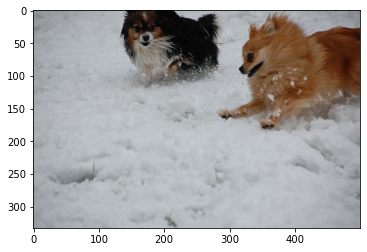

Greedy Search: a white dog is running through the snow
Beam Search, K = 3: a brown and white dog is running through the grass
Beam Search, K = 5: a brown and white dog is playing with a brown and white dog in the grass
Beam Search, K = 7: a brown and white dog is playing with a ball in the snow
Beam Search, K = 10: a brown and white dog is playing with a ball in the grass


In [30]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

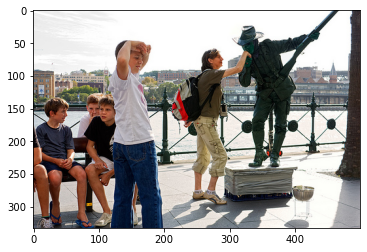

Greedy Search: a man in a black shirt and jeans is standing on a sidewalk
Beam Search, K = 3: a man in a black shirt and jeans stands on a sidewalk near a lake
Beam Search, K = 5: a man in a black shirt and jeans is standing in front of a white building
Beam Search, K = 7: a man in a black shirt and jeans is standing in front of a
Beam Search, K = 10: a group of people sit on a park bench next to a lake


In [31]:
pic = '3482062809_3b694322c4.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

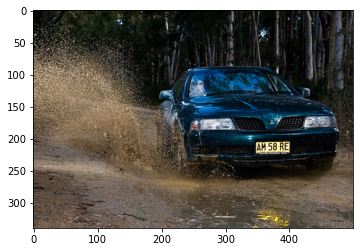

Greedy Search: a silver car is driving through a mud puddle
Beam Search, K = 3: a silver car is driving in a mud puddle
Beam Search, K = 5: a silver car is driving through a mud puddle
Beam Search, K = 7: a red jeep is driving through a mud puddle
Beam Search, K = 10: a red jeep is driving through a mud puddle


In [32]:
pic = '2943023421_e297f05e11.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

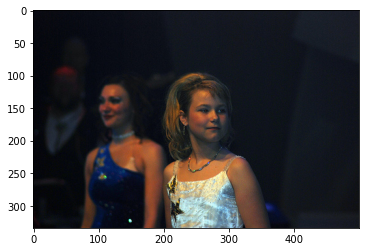

Greedy Search: a woman in a white tank top is standing in front of a crowd
Beam Search, K = 3: a woman in a white tank top has a flag in a parade
Beam Search, K = 5: a little girl in a red and white dress is standing in front of a crowd
Beam Search, K = 7: a little girl in a red and white outfit is walking in a parade
Beam Search, K = 10: a police officer in a parade in front of a crowd


In [33]:
pic = '2396691909_6b8c2f7c44.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

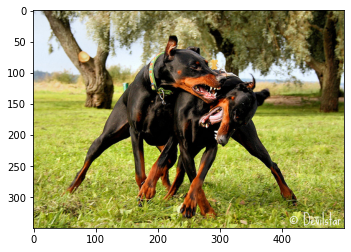

Greedy Search: a black dog is running through the grass
Beam Search, K = 3: a black and white dog is running through the grass
Beam Search, K = 5: a black and white dog and a black and white dog are playing tug of war of war
Beam Search, K = 7: a black and white dog and a black and white dog are playing tug of war of war
Beam Search, K = 10: a black and white dog and a black and white dog are playing tug of war of war


In [34]:
pic = '2869491449_1041485a6b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

## Evaluating the model's performance

For text evaluations we have a metric called as BLEU Score. BLEU stands for Bilingual Evaluation Understudy, it is a score for comparing a candidate text to one or more reference text.

In [35]:
from nltk.translate.bleu_score import sentence_bleu

In [36]:
reference = [['Three', 'people', 'running', 'on', 'the', 'road']]
candidate = ['Person', 'is', 'running', 'on', 'the', 'road']
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1,0,0,0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25)))

Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.632456
Cumulative 3-gram: 0.587949
Cumulative 4-gram: 0.508133


In [48]:
def evaluate_model(pic):
    x=plt.imread(images_path+pic)
    plt.imshow(x)
    plt.show()
    actual = [d.split() for d in descriptions[pic[:-4]]]
    #actual = descriptions[pic[:-4]][0].split()
    print("Reference caption: ", descriptions[pic[:-4]][0])
    image = encoding_test[pic].reshape((1,2048))
    
    predicted = greedySearch(image).split()
    print("Predicted caption: ", greedySearch(image))
    
    # calculating BLEU score
    print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1,0,0,0)))
    print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5,0.5,0,0)))
    print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.33,0.33,0.33,0)))
    print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

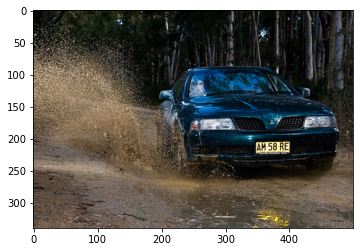

Reference caption:  a black mitsubishi is driving through a muddy puddle and spraying water 
Predicted caption:  a silver car is driving through a mud puddle
BLEU-1: 0.636917
BLEU-2: 0.413690
BLEU-3: 0.329794
BLEU-4: 0.254331


In [49]:
evaluate_model('2943023421_e297f05e11.jpg')

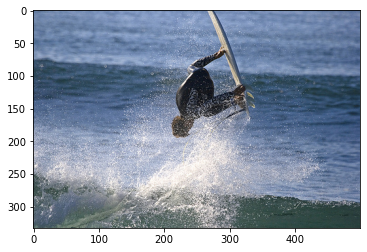

Reference caption:  a surfer does a flip on a wave 
Predicted caption:  a surfer is riding a wave
BLEU-1: 0.705401
BLEU-2: 0.598553
BLEU-3: 0.426185
BLEU-4: 0.000000


In [50]:
evaluate_model('3085667767_66041b202e.jpg')

## Generating captions for the whole test data and finding BLEU score

In [37]:
doc = open(test_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier = line.split('.')[0]
        dataset.append(identifier)

test = dataset

In [41]:
from keras.preprocessing.image import load_img

In [44]:
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for i in range(len(test)):
    p = test[i]+'.jpg'
    actual = [d.split() for d in descriptions[p[:-4]]]
    a = descriptions[p[:-4]][0]
    image = encoding_test[p].reshape((1,2048))
    pred = greedySearch(image)
    predicted = pred.split()
    
    bleu = sentence_bleu(actual, predicted, weights=(1,0,0,0))
    bleus.append(bleu)
    if bleu >= 0.60:
        pred_good.append((bleu,p,a,pred))
    else:
        pred_bad.append((bleu,p,a,pred))
        
#     if len(pred_good) >= nkeep and len(pred_bad) >= nkeep:
#         break

In [43]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.561


## Examples of good and bad captions generated by the model

We can check out how close or far apart the generated captions are from the actual captions. Complexity in images may result in bad captions.  
A few examples are as follows:

Bad Captions


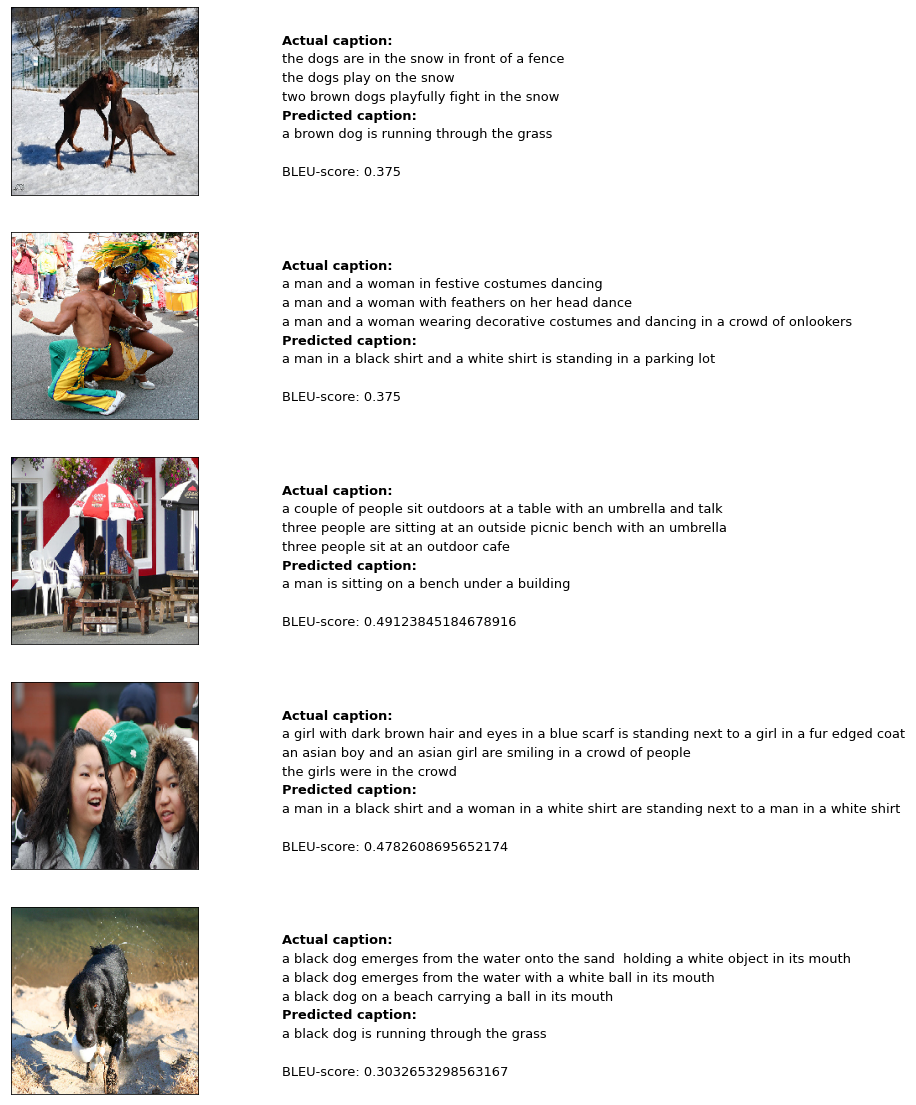

Good Captions


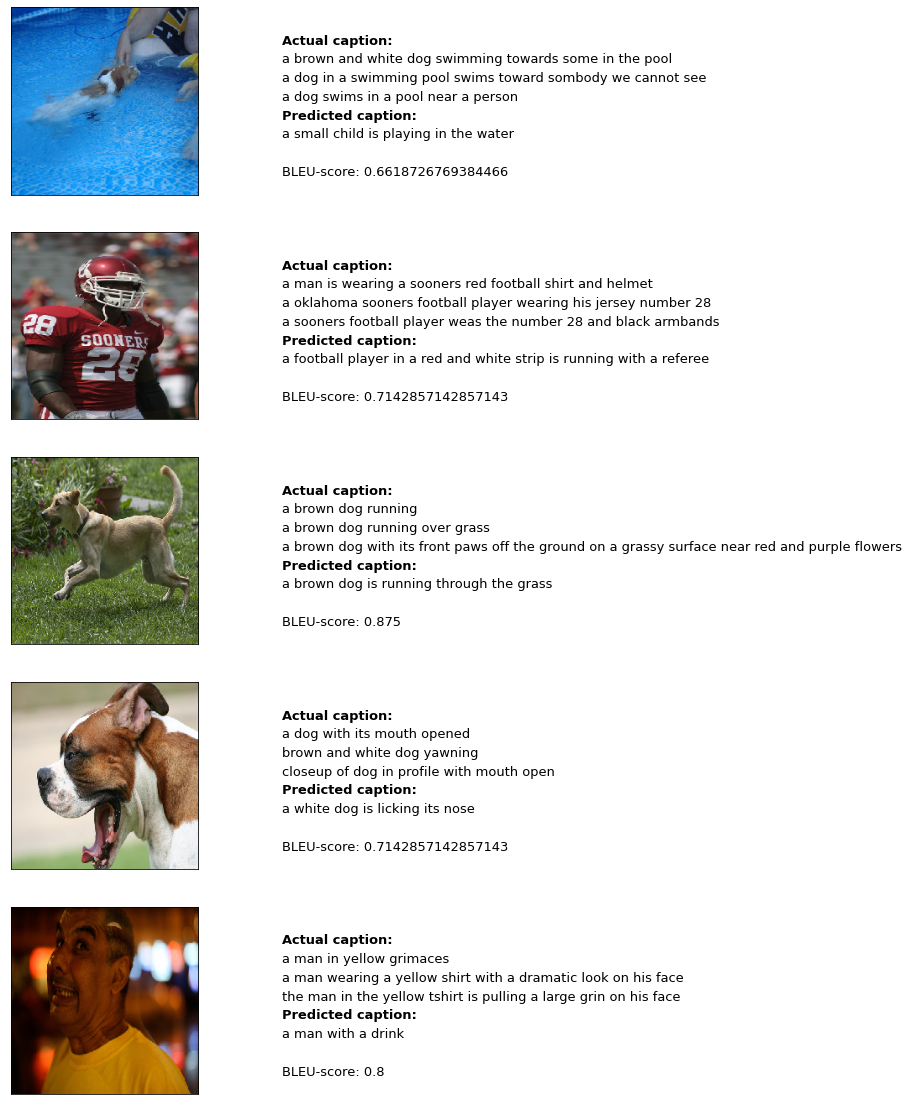

In [47]:
def plot_images(pred_bad):
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,p,a,pred = pb
        ## images 
        filename = images_path + p
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.8, "Actual caption:",fontsize=13,fontweight="bold")
        ax.text(0,0.7, str(descriptions[p[:-4]][0]),fontsize=13)
        ax.text(0,0.6, str(descriptions[p[:-4]][1]),fontsize=13)
        ax.text(0,0.5, str(descriptions[p[:-4]][2]),fontsize=13)
        ax.text(0,0.4, "Predicted caption:",fontsize=13,fontweight="bold")
        ax.text(0,0.3, pred,fontsize=13)
        ax.text(0,0.1,"BLEU-score: {}".format(bleu),fontsize=13)
        count += 1
    plt.show()

print("Bad Captions")
plot_images(pred_bad[:5])
print("Good Captions")
plot_images(pred_good[:5])